In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.optimize import minimize
from copy import deepcopy as deepcopy
import torch

def lorenz(x, y, z, s=10, r=28, b=2.667):
    """
    Given:
       x, y, z: a point of interest in three dimensional space
       s, r, b: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot

dt = 0.01
num_steps = 10000

# Need one more for the initial values
xs = np.empty(num_steps + 1)
ys = np.empty(num_steps + 1)
zs = np.empty(num_steps + 1)

# Set initial values
xs[0], ys[0], zs[0] = (1,1,1)

# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
    xs[i + 1] = xs[i] + (x_dot * dt)
    ys[i + 1] = ys[i] + (y_dot * dt)
    zs[i + 1] = zs[i] + (z_dot * dt)

data = np.asarray([xs,ys,zs])

np.shape(data)


(3, 10001)

In [2]:

u1_n = data[0,:999]
u2_n = data[1,:999]
u3_n = data[2,:999]

u1_n_1 = data[0,1:1000]
u2_n_1 = data[1,1:1000]
u3_n_1 = data[2,1:1000]

custo_física_1 =  (u1_n_1 -  (u1_n  + (10*(u2_n - u1_n))*dt) )**2
custo_física_2 =  (u2_n_1 -  (u2_n + (28*u1_n - u2_n - u1_n*u3_n)*dt) )**2
custo_física_3 =  (u3_n_1 -  (u3_n + (u1_n*u2_n - 2.667*u3_n)*dt) )**2


custo_física_3

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [3]:
class ESN:

    def __init__(self, tam_input, tam_output, tam_reservatorio,u,data,tam_treino,tam_test,tam_teacher_force,warm_up):

        self.tam_input = tam_input
        self.tam_output = tam_output
        self.tam_reservatorio = tam_reservatorio

        self.data = data
        self.tam_treino = tam_treino
        self.tam_test = tam_test
        self.tam_teacher_force = tam_teacher_force
        self.warm_up = warm_up
        self.u = u

        self.W = None
        self.Win = None
        self.Wf = None
        self.Wout = None
        
        self.data_treino = None
        self.data_test = None
        self.noise = None
        self.xs = None
        self.ys = None
        self.zs = None
        self.xs_n = None
        self.ys_n = None
        self.zs_n = None
        self.data_n = None
        self.y_last_result = None
        self.x_test = None

        self.last_state = None
        self.result = None
        self.X_otimizador = None

    def split_data(self,noise_value):
        
        xs = self.data[0,:]
        ys = self.data[1,:]
        zs = self.data[2,:]

        self.xs = xs
        self.ys = ys
        self.zs = zs

        #Retirando a normalização

        #data_norm_1 = (xs - xs.min())/ (xs.max() - xs.min())
        #data_norm_2 = (ys - ys.min())/ (ys.max() - ys.min())
        #data_norm_3 = (zs - zs.min())/ (zs.max() - zs.min())

        data_norm_1 = xs
        data_norm_2 = ys
        data_norm_3 = zs

        self.xs_n = data_norm_1
        self.ys_n = data_norm_2
        self.zs_n = data_norm_3

        data_n = np.asarray([data_norm_1,data_norm_2,data_norm_3])

        self.data_n = data_n

        self.data_treino = data_n[:,:self.tam_treino]

        self.data_test = data_n[:,self.tam_treino:self.tam_treino+self.tam_teacher_force]

        self.noise = np.random.uniform(-noise_value, noise_value, self.data_treino.shape)

        self.Yt = data_n[:, self.warm_up + 1: self.tam_treino + 1] 


    def gerar_pesos(self, value_spectral_r):
        
        W =  np.random.uniform(-1,1,[self.tam_reservatorio,self.tam_reservatorio])

        eigenvalues , eigenvectors = np.linalg.eig(W)
        spectral_r = np.max(np.abs(eigenvalues))

        self.W = W * value_spectral_r/spectral_r

        self.Win = np.random.choice([0,-0.15,0.15], [self.tam_reservatorio,self.tam_input], p=[0.5, 0.25, 0.25])

        a = np.zeros([self.tam_reservatorio,self.tam_output])

        for i in range(self.tam_reservatorio):

            index = np.random.choice([0,1,2], 1, p=[1/3,1/3,1/3])

            a[i,index] = np.random.uniform(-0.15,0.15)

        self.Wf = a #np.random.uniform(-0.15,0.15,[self.tam_reservatorio,self.tam_output])
    
    def treino(self, reg):

        a = 1
        C = 1 # global constant

        X = np.zeros((self.tam_reservatorio,self.tam_treino))

        x = np.zeros((self.tam_reservatorio,1))

        for t in range(self.tam_treino):

            data_feedback = self.data_treino[:,t]
            data_feedback = np.reshape(data_feedback,(self.tam_output,1))

            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, data_feedback))
            X[:,t] = np.vstack(x)[:,0]

        X = X[:,self.warm_up:]

        self.X_otimizador = X

        self.Wout = np.dot( np.dot(self.Yt, (X.T)), np.linalg.inv(np.dot(X,(X.T)) +  reg*np.eye(self.tam_reservatorio)))

        self.last_state = x

    def test(self,Wout):

        a = 1
        C = 1 # global constant

        Y = np.zeros((self.tam_output,self.tam_test+self.tam_teacher_force))

        x = self.last_state

        y = self.X_otimizador.T@self.Wout.T
        y = y[-1,:]

        for t in range(self.tam_teacher_force):

            data_feedback = self.data_test[:,t]
            data_feedback = np.reshape(data_feedback,(self.tam_output,1))
            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, data_feedback))
            y = np.dot(Wout, x)
            y = np.reshape(y,(self.tam_output))
            Y[:,t] = y

        self.x_test = np.zeros((self.tam_reservatorio,self.tam_test)) 

        for t in range(self.tam_test):

            y = np.reshape(y,(self.tam_output,1))
            x = (1-C*a)*x + C*np.tanh( np.dot(self.Win, self.u)  + np.dot(self.W, x) + np.dot(self.Wf, y))
            y = np.dot(Wout, x)
            y = np.reshape(y,(self.tam_output))
            self.x_test[:,t] = np.reshape(x,(self.tam_reservatorio))
            Y[:,t+self.tam_teacher_force] = y
        
        self.result = Y


In [4]:
#dados rede
np.random.seed(44)
tam_treino = 1000
tam_teste = 1000
tam_teste_teacher = 0
warm_up = 0
tam_input = 3
tam_output = 3
tam_reservatorio = 200
noise_value = 0
spectral_r = 0.4
reg = 1e-5
u = np.asarray([0,0,0])
u = np.reshape(u,(3,1))





In [5]:
test = ESN(tam_input,tam_output,tam_reservatorio,u,data,tam_treino,tam_teste,tam_teste_teacher,warm_up)
test.split_data(noise_value)
test.gerar_pesos(spectral_r)
test.treino(reg)
test.test(test.Wout)



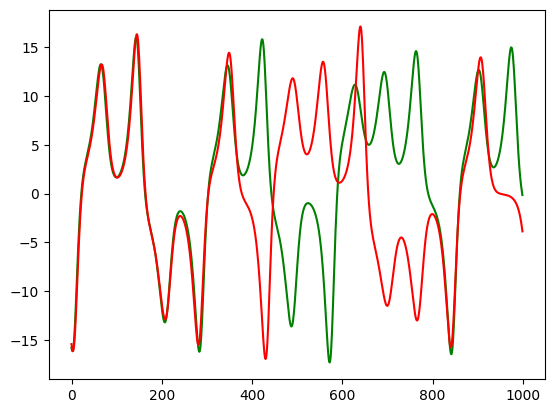

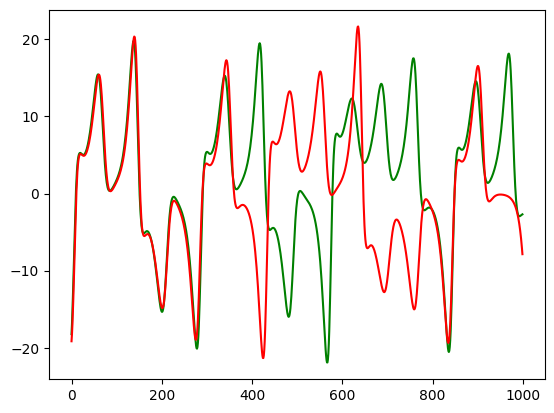

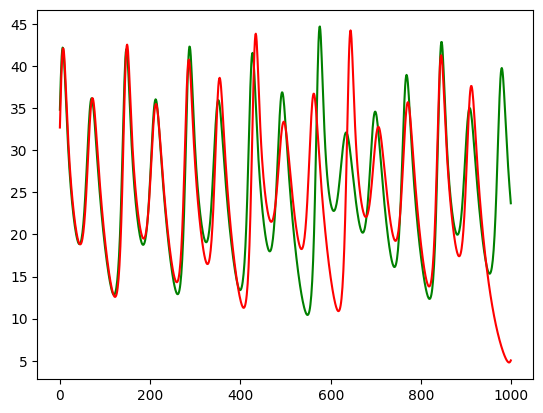

In [6]:
corte_dados = test.tam_treino+test.tam_teacher_force

previsao_x = deepcopy(test.result.T[test.tam_teacher_force:test.tam_teacher_force+1000,0])
resultado_x = test.data_n.T[corte_dados:corte_dados+1000,0]

previsao_y = deepcopy(test.result.T[test.tam_teacher_force:test.tam_teacher_force+1000,1])
resultado_y = test.data_n.T[corte_dados:corte_dados+1000,1]

previsao_z = deepcopy(test.result.T[test.tam_teacher_force:test.tam_teacher_force+1000,2])
resultado_z = test.data_n.T[corte_dados:corte_dados+1000,2]

plot1 = plt. figure(1)
plt. plot(previsao_x,'g')
plt. plot(resultado_x,'r')
plot2 = plt. figure(2)
plt. plot(previsao_y,'g')
plt. plot(resultado_y,'r')
plot3 = plt. figure(3)
plt. plot(previsao_z,'g')
plt. plot(resultado_z,'r')


In [36]:
teste_o = deepcopy(test)


In [37]:
#Wout_torch = torch.tensor(np.random.uniform(-1,1,[test.tam_reservatorio,test.tam_output]), requires_grad=True)
Wout_torch = torch.tensor(teste_o.Wout.T, requires_grad=True)
x_test = torch.tensor(teste_o.x_test, requires_grad=False)
optimizer = torch.optim.Adam([Wout_torch])


In [40]:
erro_list  = []

custo_list  = []

for j in range(30):
    
    x_test = torch.tensor(teste_o.x_test, requires_grad=False)

    for i in range(100):

        optimizer.zero_grad()
        x_test = torch.tensor(teste_o.x_test, requires_grad=False)

        y = Wout_torch.T @ x_test
        dt = 0.01
        sigma = 10
        rho = 28
        beta = (8/3)

        n_amostras = 3000
        yt = torch.tensor(teste_o.Yt.T, requires_grad=False)
        X = torch.tensor(teste_o.X_otimizador.T, requires_grad=False)

        cost = (1/(2*n_amostras))*torch.sum((X@Wout_torch - yt)**2)

        u1_n = y[0,:999]
        u2_n = y[1,:999]
        u3_n = y[2,:999]

        u1_n_1 = y[0,1:]
        u2_n_1 = y[1,1:]
        u3_n_1 = y[2,1:]

        custo_física_1 =  (u1_n_1 -  (u1_n  + (sigma*(u2_n - u1_n))*dt) )**2
        custo_física_2 =  (u2_n_1 -  (u2_n + (rho*u1_n - u2_n - u1_n*u3_n)*dt) )**2
        custo_física_3 =  (u3_n_1 -  (u3_n + (u1_n*u2_n - beta*u3_n)*dt) )**2

        custo_física = torch.sum(custo_física_1 + custo_física_2 + custo_física_3)/(n_amostras)

        custo_total_t = custo_física + cost

        custo_total_t.backward()

        optimizer.step()
    
        theta = Wout_torch.detach().numpy()

        erro1 = np.sum(((theta.T@teste_o.x_test).T[:,0] - resultado_x)**2)/1000
        erro2 = np.sum(((theta.T@teste_o.x_test).T[:,1] - resultado_y)**2)/1000
        erro3 = np.sum(((theta.T@teste_o.x_test).T[:,2] - resultado_z)**2)/1000
        erro = erro1+erro2+erro3
        erro_list.append(erro)

        custo_total = custo_total_t.detach().numpy()
        custo_list.append(custo_total)
    
    teste_o.test(theta.T)

    erro1 = np.sum(((theta.T@teste_o.x_test).T[:,0] - resultado_x)**2)/1000
    erro2 = np.sum(((theta.T@teste_o.x_test).T[:,1] - resultado_y)**2)/1000
    erro3 = np.sum(((theta.T@teste_o.x_test).T[:,2] - resultado_z)**2)/1000
    erro = erro1+erro2+erro3
    erro_list.append(erro)

    custo_total = custo_total_t.detach().numpy()
    custo_list.append(custo_total)



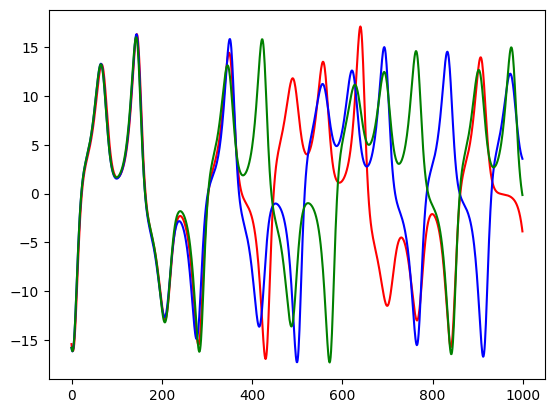

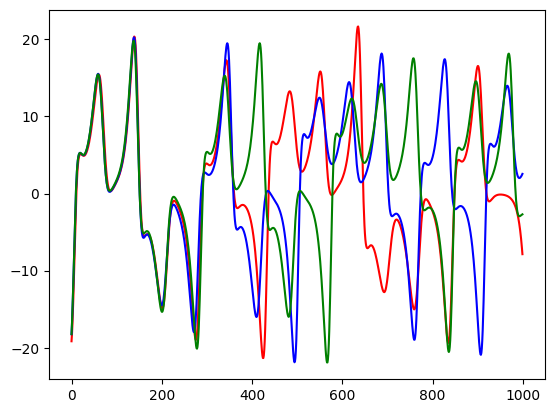

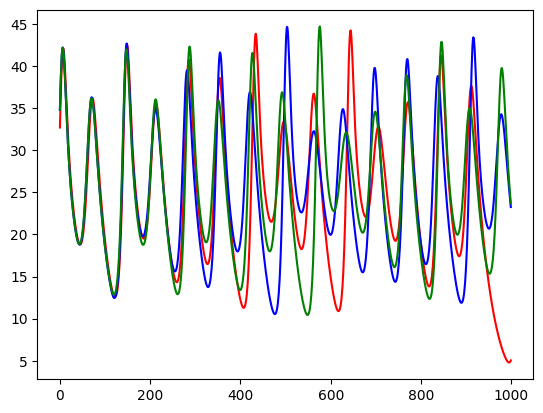

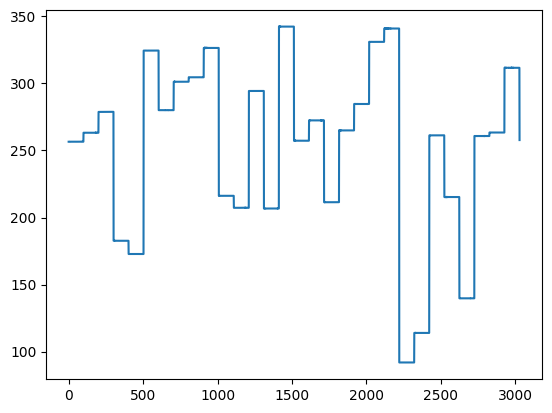

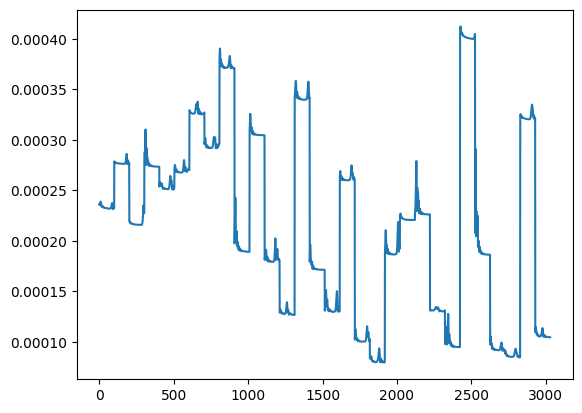

In [41]:

theta = Wout_torch.detach().numpy()
test.test(theta.T)
plot1 = plt. figure(1)
plt. plot(resultado_x,'r')
plt.plot((theta.T@teste_o.x_test).T[:,0],'b')
plt. plot(previsao_x,'g')
plot2 = plt. figure(2)
plt. plot(resultado_y,'r')
plt.plot((theta.T@teste_o.x_test).T[:,1],'b')
plt. plot(previsao_y,'g')
plot3 = plt. figure(3)
plt. plot(resultado_z,'r')
plt.plot((theta.T@teste_o.x_test).T[:,2],'b')
plt. plot(previsao_z,'g')

plot4 = plt. figure(4)
plt.plot(erro_list)
plot5 = plt. figure(5)
plt.plot(custo_list)


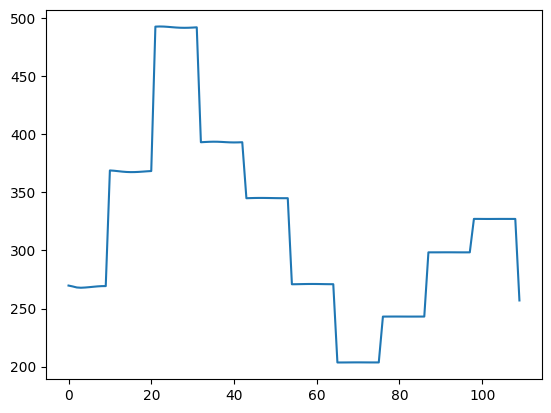

In [20]:
plt.plot(erro_list)


In [ ]:
n_x_test = list(range(1,11))

#for x in range(1,11):
#    n_x_test.append(x)

n_opt_test = list(range(100,300,100))
#for opt in range(100,300,100):
#    n_opt_test.append(opt)

erro_list = []
index_list = []
loss = np.zeros([len(n_x_test), len(n_opt_test)])
index_n = 0
index_m = 0

for n in n_x_test:
    for j in range(n):
            x_test = torch.tensor(test.x_test, requires_grad=True)

            for m in n_opt_test:

                for i in range(m):

                    optimizer.zero_grad()
                    x_test = torch.tensor(test.x_test, requires_grad=True)

                    y = Wout_torch.T @ x_test
                    dt = 0.01
                    sigma = 10
                    rho = 28
                    beta = (8/3)

                    n_amostras = 3000
                    yt = torch.tensor(test.Yt.T, requires_grad=False)
                    X = torch.tensor(test.X_otimizador.T, requires_grad=False)

                    cost = (1/(2*n_amostras))*torch.sum((X@Wout_torch - yt)**2)

                    u1_n = y[0,:999]
                    u2_n = y[1,:999]
                    u3_n = y[2,:999]

                    u1_n_1 = y[0,1:]
                    u2_n_1 = y[1,1:]
                    u3_n_1 = y[2,1:]

                    custo_física_1 =  (u1_n_1 -  (u1_n  + (sigma*(u2_n - u1_n))*dt) )**2
                    custo_física_2 =  (u2_n_1 -  (u2_n + (rho*u1_n - u2_n - u1_n*u3_n)*dt) )**2
                    custo_física_3 =  (u3_n_1 -  (u3_n + (u1_n*u2_n - beta*u3_n)*dt) )**2

                    custo_física = torch.sum(custo_física_1 + custo_física_2 + custo_física_3)/(n_amostras)

                    custo_total_t = custo_física + cost

                    custo_total_t.backward()

                    optimizer.step()
                
                theta = Wout_torch.detach().numpy()

                erro1 = np.sum(((theta.T@test.x_test).T[:,0] - resultado_x)**2)/1000
                erro2 = np.sum(((theta.T@test.x_test).T[:,1] - resultado_y)**2)/1000
                erro3 = np.sum(((theta.T@test.x_test).T[:,2] - resultado_z)**2)/1000
                erro = erro1+erro2+erro3
                erro_list.append(erro)
                index_list.append('Numero de otimizações: '+ str(m)+ ' Numero de atualizações x_test: ' + str(n) + ' Erro = ' + str(erro) ) 
                loss[index_n,index_m] = erro
                index_m = index_m+1
                print(index_m)
            
            print(index_n)
            theta = Wout_torch.detach().numpy()
            test.test(theta.T)
            index_n = index_n+1


In [ ]:



plt.figure(figsize=(16,8))
im = plt.imshow(loss.T, vmin=abs(loss).min(), vmax=abs(loss).max(), origin='lower',cmap='PuRd')
plt.xticks(np.linspace(0,len(n_x_test)-1,len(n_x_test)), n_x_test)
plt.yticks(np.linspace(0,len(n_opt_test)-1, len(n_opt_test)), n_opt_test)
plt.xlabel('N atualizacoes de x_test', fontsize=16)
plt.ylabel('N de passos de otimizacao', fontsize=16)
plt.savefig('busca_grade.jpg', format='jpg')

cb = plt.colorbar(im); 


In [ ]:
theta = Wout_torch.detach().numpy()
#test.Wout = theta.T
test.test(theta.T)
plot1 = plt. figure(j, clear = True)
plt.title('U1 iteracao ' + str(j))
plt. plot(resultado_x,'black')
plt.plot((theta.T@test.x_test).T[:,0],'g')
plt. plot(previsao_x,'b', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.savefig('u1_'+str(j)+'.jpg', format='jpg')
#plt.show()

plot2 = plt. figure(j+1, clear = True)
plt.title('U2 iteracao ' + str(j))
plt. plot(resultado_y,'black')
plt.plot((theta.T@test.x_test).T[:,1],'g')
plt. plot(previsao_y,'b', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.savefig('u2_'+str(j)+'.jpg', format='jpg')
#plt.show()

plot3 = plt. figure(j+2, clear = True)
plt.title('U3 iteracao ' + str(j))
plt. plot(resultado_z,'black')
plt.plot((theta.T@test.x_test).T[:,2],'g')
plt. plot(previsao_z,'b', linestyle = "dotted")
plt.legend(["Sistema","PI-ESN","ESN"]) 
plt.savefig('u3_'+str(j)+'.jpg', format='jpg')
#plt.show()

plt.close('all')



In [42]:
np.shape(resultado_x)

(1000,)